### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupKFold
from scipy import stats
import os
from tqdm import tqdm
import utils  # Do seu utils.py

### Audio Preprocessing

In [2]:
# --- Configuração ---
METADATA_DIR = '../fma_metadata'
AUDIO_DIR_GENRES = '../fma_datasets/fma_small_genres'
# Arquivos de cache para os espectrogramas
FEATURE_FILE_X = '../preprocessed_features/fma_small_spectrograms_X_3s_25overlap.npy'
FEATURE_FILE_y = '../preprocessed_features/fma_small_spectrograms_y_3s_25overlap.npy'
FEATURE_FILE_groups = '../preprocessed_features/fma_small_spectrograms_groups_3s_25overlap.npy'
N_CLASSES = 8 # 8 gêneros no fma_small

# --- Carregar Metadados (Igual ao v2) ---
tracks = utils.load(f'{METADATA_DIR}/tracks.csv')

small_mask = tracks[('set', 'subset')] == 'small'
y_all_labels_pd = tracks.loc[small_mask, ('track', 'genre_top')]
splits_pd = tracks.loc[small_mask, ('set', 'split')]

# --- Codificar os Gêneros (Labels) ---
label_encoder = LabelEncoder()
y_all_encoded_np = label_encoder.fit_transform(y_all_labels_pd).astype(np.int32)
class_names = label_encoder.classes_

# --- Criar DataFrame de referência ---
track_metadata = pd.DataFrame({
    'genre_top': y_all_labels_pd,
    'genre_encoded': y_all_encoded_np,
    'split': splits_pd
}, index=y_all_labels_pd.index)

print(f"Metadados carregados para {track_metadata.shape[0]} faixas 'small'.")
print(f"Gêneros: {class_names}")

Metadados carregados para 8000 faixas 'small'.
Gêneros: ['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']


In [3]:
# Parâmetros de Janelamento e Espectrograma
WINDOW_SIZE_SEC = 3
OVERLAP_PERCENT = 0.25
SR = 22050
N_MELS = 128   # Altura da "imagem" do espectrograma
N_FFT = 2048
HOP_LENGTH = 512 # Resultará na "largura" da imagem

# CALCULA A LARGURA FIXA (shape[1])
SPEC_WIDTH = int(np.ceil((WINDOW_SIZE_SEC * SR) / HOP_LENGTH))
SPEC_SHAPE = (N_MELS, SPEC_WIDTH)

def gerar_melspectrogram_janelado(file_path, sr=SR, window_size_sec=WINDOW_SIZE_SEC, overlap_percent=OVERLAP_PERCENT, target_shape=SPEC_SHAPE, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """
    Extrai mel-espectrogramas de 3s com 25% de sobreposição.
    MODIFICADO para garantir shape fixo (padding/truncate).
    """
    all_window_specs = []
    
    try:
        y, sr_loaded = librosa.load(file_path, mono=True, sr=sr, res_type='kaiser_fast')
        
        samples_per_window = window_size_sec * sr
        hop_size = int(samples_per_window * (1.0 - overlap_percent))
        
        if len(y) < samples_per_window:
            #print(f"Aviso: Áudio {file_path} mais curto que {window_size_sec}s. Pulando.")
            return []

        # Cria as janelas (frames) com sobreposição (lógica do v2)
        y_frames = librosa.util.frame(y, frame_length=samples_per_window, hop_length=hop_size, axis=0)
        
        for y_window in y_frames:
            # Gera o Mel-Espectrograma para a janela
            S = librosa.feature.melspectrogram(y=y_window, sr=sr, n_mels=target_shape[0], n_fft=n_fft, hop_length=hop_length)
            # Converte para dB
            S_db = librosa.power_to_db(S, ref=np.max)
            
            # Garante que a "largura" do espectrograma seja consistente
            # Isso evita o erro de "pickle" do NumPy
            S_db = librosa.util.fix_length(S_db, size=target_shape[1], axis=1)
            
            all_window_specs.append(S_db.astype(np.float32)) # Salva como float32
            
    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return []
        
    return all_window_specs

In [4]:
# Para garantir que as variáveis existam fora do escopo do 'if'
X_np = None
y_encoded_np = None
groups_np = None

# Verifica se os arquivos de cache existem
if not (os.path.exists(FEATURE_FILE_X) and 
        os.path.exists(FEATURE_FILE_y) and 
        os.path.exists(FEATURE_FILE_groups)):
    
    print(f"Arquivos de espectrograma não encontrados. Iniciando extração (2 passagens)...")
    
    # --- PASSAGEM 1: Contar o número total de janelas ---
    
    def get_window_count(file_path, sr=SR, window_size_sec=WINDOW_SIZE_SEC, overlap_percent=OVERLAP_PERCENT):
        # Esta função é mais leve, apenas carrega o áudio e conta os frames
        try:
            y, sr_loaded = librosa.load(file_path, mono=True, sr=sr, res_type='kaiser_fast')
            samples_per_window = window_size_sec * sr
            if len(y) < samples_per_window: return 0
            hop_size = int(samples_per_window * (1.0 - overlap_percent))
            y_frames = librosa.util.frame(y, frame_length=samples_per_window, hop_length=hop_size, axis=0)
            return y_frames.shape[0] # Retorna o número de janelas
        except Exception:
            return 0

    print("Passagem 1/2: Contando janelas...")
    total_janelas = 0
    all_track_ids_para_contagem = [] # Usado para saber quais faixas processar na Passagem 2
    
    for track_id, row in tqdm(track_metadata.iterrows(), total=track_metadata.shape[0]):
        genre_top = row['genre_top']
        file_path = f"{AUDIO_DIR_GENRES}/{genre_top}/{track_id:06d}.mp3"
        
        if not os.path.exists(file_path): continue
            
        n_janelas = get_window_count(file_path)
        if n_janelas > 0:
            total_janelas += n_janelas
            all_track_ids_para_contagem.append((track_id, row, n_janelas))

    print(f"\nContagem concluída. Total de janelas a serem extraídas: {total_janelas}")
    
    # --- PASSAGEM 2: Extrair e Salvar em Arrays (memmap) ---
    
    # Usa o SPEC_SHAPE definido na Célula 3 (ex: (128, 130))
    final_shape = (total_janelas, SPEC_SHAPE[0], SPEC_SHAPE[1])
    
    # Cria os arrays no disco (np.memmap para X)
    os.makedirs(os.path.dirname(FEATURE_FILE_X), exist_ok=True)
    
    # Criamos um nome temporário para o arquivo memmap
    MEMMAP_TEMP_FILE = FEATURE_FILE_X + '.temp'
    if os.path.exists(MEMMAP_TEMP_FILE):
        os.remove(MEMMAP_TEMP_FILE)
        
    X_np_memmap = np.memmap(MEMMAP_TEMP_FILE, dtype='float32', mode='w+', shape=final_shape)
    y_encoded_np_temp = np.zeros(total_janelas, dtype=np.int32)
    groups_np_temp = np.zeros(total_janelas, dtype=np.int32)

    print(f"Passagem 2/2: Extraindo espectrogramas para {MEMMAP_TEMP_FILE} (Shape: {final_shape})...")
    
    idx_escrita_atual = 0
    
    for track_id, row, n_janelas in tqdm(all_track_ids_para_contagem):
        genre_top = row['genre_top']
        file_path = f"{AUDIO_DIR_GENRES}/{genre_top}/{track_id:06d}.mp3"
        
        window_specs = gerar_melspectrogram_janelado(file_path)
        
        for i, spec in enumerate(window_specs):
            if i >= n_janelas: break 
            
            X_np_memmap[idx_escrita_atual] = spec
            y_encoded_np_temp[idx_escrita_atual] = row['genre_encoded']
            groups_np_temp[idx_escrita_atual] = track_id
            idx_escrita_atual += 1
    
    # 1. Salva o X (lendo do memmap e salvando como .npy)
    print(f"\nConvertendo {MEMMAP_TEMP_FILE} para {FEATURE_FILE_X}...")
    np.save(FEATURE_FILE_X, X_np_memmap)
    
    # 2. Fecha e deleta o arquivo memmap temporário
    del X_np_memmap
    os.remove(MEMMAP_TEMP_FILE)
    
    # 3. Salva os outros arrays
    np.save(FEATURE_FILE_y, y_encoded_np_temp)
    np.save(FEATURE_FILE_groups, groups_np_temp)
    print(f"Extração concluída. Arquivos salvos.")
    
    # 4. Agora, carregamos as variáveis (do .npy recém-criado)
    print(f"Carregando arquivos recém-criados do cache...")
    X_np = np.load(FEATURE_FILE_X, mmap_mode='r')
    y_encoded_np = np.load(FEATURE_FILE_y)
    groups_np = np.load(FEATURE_FILE_groups)

else:
    print(f"Carregando espectrogramas cacheados de {FEATURE_FILE_X}...")
    # Carrega do disco (usando mmap_mode='r')
    X_np = np.load(FEATURE_FILE_X, mmap_mode='r') # <-- Esta linha agora funcionará
    y_encoded_np = np.load(FEATURE_FILE_y)
    groups_np = np.load(FEATURE_FILE_groups)
    print("Arquivos carregados.")

# Estas linhas agora funcionarão
print(f"Shape de X (amostras, n_mels, frames): {X_np.shape}")
print(f"Shape de y (labels): {y_encoded_np.shape}")
print(f"Shape de groups (track_ids): {groups_np.shape}")

Carregando espectrogramas cacheados de ../preprocessed_features/fma_small_spectrograms_X_3s_25overlap.npy...
Arquivos carregados.
Shape de X (amostras, n_mels, frames): (99278, 128, 130)
Shape de y (labels): (99278,)
Shape de groups (track_ids): (99278,)


### Treino dos Modelos

In [5]:
import os
# Desabilita otimizações XLA que podem consumir memória extra na compilação
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

import tensorflow as tf

# Configuração crítica para evitar travamento em GPUs com pouca VRAM (6GB)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU Memory Growth habilitado para: {gpus}")
    except RuntimeError as e:
        print(e)

2025-11-23 16:11:00.047478: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-23 16:11:00.476598: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-23 16:11:02.146409: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU Memory Growth habilitado para: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (InputLayer, Conv2D, MaxPooling2D, 
                                     BatchNormalization, Dropout, 
                                     GlobalAveragePooling2D, Dense, Activation)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW

# Adiciona a dimensão do "canal" (1, pois é escala de cinza/monocromático)
X_np_cnn = X_np[..., np.newaxis]

# Converte labels para one-hot encoding
y_one_hot = tf.keras.utils.to_categorical(y_encoded_np, num_classes=N_CLASSES)

print(f"Shape de X para CNN (amostras, altura, largura, canais): {X_np_cnn.shape}")
print(f"Shape de y (one-hot): {y_one_hot.shape}")

Shape de X para CNN (amostras, altura, largura, canais): (99278, 128, 130, 1)
Shape de y (one-hot): (99278, 8)


In [7]:

def build_cnn_model(input_shape, num_classes):
    """
    Arquitetura inspirada na VGG, otimizada para Mel-Espectrogramas.
    Usa GlobalAveragePooling para reduzir parâmetros na camada densa.
    """
    weight_decay = 0.0005  # Regularização L2 para evitar overfitting

    model = Sequential()
    model.add(InputLayer(shape=input_shape))

    # --- Bloco 1 (Recursos de Baixo Nível / Timbre) ---
    # 32 Filtros
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # --- Bloco 2 ---
    # 64 Filtros
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # --- Bloco 3 ---
    # 128 Filtros
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    # --- Bloco 4 (Recursos de Alto Nível / Estrutura) ---
    # 256 Filtros - Aprofundando, mas parando aqui para economizar VRAM
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    
    # --- Classificador (Head) ---
    # Global Average Pooling 
    # Transforma (H, W, 256) -> vetor de (256)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(weight_decay)))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax', dtype='float32'))
    
    return model

# Pega o shape de uma amostra (altura, largura, canais)
input_shape = X_np_cnn.shape[1:] 
model_cnn = build_cnn_model(input_shape, N_CLASSES)
model_cnn.summary()

I0000 00:00:1763928663.092560    5888 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 130, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 130, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 130, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 130, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 130, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 130, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 65, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 65, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 128)    │             

 Total params: 1,243,368 (4.74 MB)

 Trainable params: 1,241,448 (4.74 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [8]:
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import mixed_precision
import gc

# Isso usa float16 para cálculos pesados e float32 para variáveis, economizando VRAM.
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print("Mixed Precision ativado: mixed_float16")

n_splits = 10
gkf = GroupKFold(n_splits=n_splits)

# Armazenar resultados
fold_scores_acc_window = []
fold_scores_acc_track = []
all_preds_track = []
all_true_track = []

BATCH_SIZE = 32 # Reduzido para garantir estabilidade na RTX 3060

def apply_spec_augment(spectrogram, time_mask_param=20, freq_mask_param=15, num_masks=1):
    """
    Aplica mascaramento de tempo e frequência no espectrograma.
    Entrada: (128, 130, 1) ou (128, 130)
    """
    # Garante que é uma cópia para não alterar o original
    aug_spec = spectrogram.copy()
    
    # Se tiver canal (H, W, C), remove para processar
    if aug_spec.ndim == 3:
        aug_spec = aug_spec[:, :, 0]
        
    n_mels, n_steps = aug_spec.shape
    
    # Mascaramento de Frequência
    for _ in range(num_masks):
        f = np.random.randint(0, freq_mask_param)
        f0 = np.random.randint(0, n_mels - f)
        aug_spec[f0:f0+f, :] = 0
        
    # Mascaramento de Tempo
    for _ in range(num_masks):
        t = np.random.randint(0, time_mask_param)
        t0 = np.random.randint(0, n_steps - t)
        aug_spec[:, t0:t0+t] = 0
        
    # Retorna dimensão do canal
    return aug_spec[..., np.newaxis]

# Função do Gerador (Mesma lógica, apenas garantindo consistência)
def data_generator(indices, batch_size, augment=False):
    num_samples = len(indices)
    while True:
        indices_shuffled = shuffle(indices)
        for offset in range(0, num_samples, batch_size):
            batch_indices = indices_shuffled[offset:offset + batch_size]

            # Carrega do disco (memmap)
            X_batch = X_np_cnn[batch_indices]
            y_batch = y_one_hot[batch_indices]
            
            # O Scaler deve ser aplicado na versão achatada e depois reshape (reshape para 2D -> transform -> reshape volta)
            # (Assumindo que o scaler foi fitado no loop principal)
            original_shape = X_batch.shape
            X_b_flat = X_batch.reshape(original_shape[0], -1)
            X_b_scaled = scaler.transform(X_b_flat).reshape(original_shape)
            
            # Aplica Augmentation apenas no Treino
            if augment:
                X_b_final = np.array([apply_spec_augment(x) for x in X_b_scaled])
            else:
                X_b_final = X_b_scaled
            
            yield X_b_final, y_batch

# Loop de Validação Cruzada (GroupKFold)
for fold, (train_idx, test_idx) in enumerate(gkf.split(X_np_cnn, y_one_hot, groups=groups_np)):
    print(f"\n=== Iniciando Fold {fold+1}/{n_splits} ===")
    
    # Limpeza de memória preventiva
    tf.keras.backend.clear_session()
    gc.collect()

    # 1. Ajustar Scaler (StandardScaler)
    print("Ajustando o Scaler (partial_fit)...")
    scaler = StandardScaler()
    train_idx_shuffled = shuffle(train_idx)
    chunk_size = 5000   # Ajusta o scaler em lotes de 5000 amostras, para não estourar a RAM

    for i in range(0, len(train_idx_shuffled), chunk_size):
        idx = train_idx_shuffled[i:i+chunk_size]
        X_chunk = X_np_cnn[idx].reshape(len(idx), -1)
        scaler.partial_fit(X_chunk)
        del X_chunk

    print("Scaler ajustado.")

    # 2. Preparar Validação
    print("Preparando validação...")
    X_test = X_np_cnn[test_idx]
    y_test = y_one_hot[test_idx]
    X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

    # Liberar memória das cópias não usadas
    del X_test
    gc.collect()

    # Dados auxiliares para votação
    groups_test_fold = groups_np[test_idx]
    y_true_labels_fold = y_encoded_np[test_idx]
    
    # 3. Callbacks e Compilação 
    # Recriamos o modelo do zero a cada fold para não vazar pesos
    model_cnn = build_cnn_model(input_shape, N_CLASSES)

    # Usando AdamW para melhor generalização
    optimizer = AdamW(learning_rate=0.001, weight_decay=0.004)
    
    model_cnn.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

    # ReduceLROnPlateau: Reduz LR se val_loss não melhorar por 3 épocas
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    # 4. Treino com SpecAugmentation
    train_gen = data_generator(train_idx, BATCH_SIZE, augment=True)
    steps_per_epoch = len(train_idx) // BATCH_SIZE
    
    print(f"Treinando com Batch Size: {BATCH_SIZE}...")
    history = model_cnn.fit(
        train_gen,
        epochs=60,
        steps_per_epoch=steps_per_epoch,
        validation_data=(X_test_scaled, y_test),
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )
    
    # 5. Avaliação (Janela)
    loss, acc = model_cnn.evaluate(X_test_scaled, y_test, verbose=0)
    fold_scores_acc_window.append(acc)

    # 6. Avaliação (Faixa - Votação Majoritária)
    # Predição em batches para economizar VRAM na inferência
    y_pred_probs = model_cnn.predict(X_test_scaled, batch_size=32, verbose=0)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    
    df_fold = pd.DataFrame({
        'track_id': groups_test_fold,
        'y_true': y_true_labels_fold,
        'y_pred': y_pred_labels
    })
    
    grouped = df_fold.groupby('track_id')
    y_true_track = grouped['y_true'].first()
    y_pred_track = grouped['y_pred'].apply(lambda x: stats.mode(x, keepdims=True)[0][0])
    
    acc_track = np.mean(y_true_track == y_pred_track)
    fold_scores_acc_track.append(acc_track)
    
    print(f"Fold {fold+1}: Acc Janela={acc:.4f} | Acc Faixa={acc_track:.4f}")
    
    # Armazenar predições globais
    all_preds_track.append(y_pred_track.values)
    all_true_track.append(y_true_track.values)
    
    # Limpeza final do fold
    del model_cnn, scaler, X_test_scaled, y_test, y_pred_probs, df_fold
    tf.keras.backend.clear_session()
    gc.collect()

print("\n--- CV Concluído ---")

Mixed Precision ativado: mixed_float16

=== Iniciando Fold 1/10 ===
Ajustando o Scaler (partial_fit)...
Scaler ajustado.
Preparando validação...
Treinando com Batch Size: 32...
Epoch 1/60


2025-11-23 16:11:30.949538: I external/local_xla/xla/service/service.cc:163] XLA service 0x7cae04009ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-23 16:11:30.949570: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-11-23 16:11:31.076630: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-23 16:11:31.684242: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-11-23 16:11:32.084466: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-23 16:11:32.

2791/2791 ━━━━━━━━━━━━━━━━━━━━ 141s 44ms/step - accuracy: 0.4207 - loss: 1.8272 - val_accuracy: 0.3412 - val_loss: 2.2892 - learning_rate: 0.0010
Epoch 2/60
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 135s 43ms/step - accuracy: 0.4911 - loss: 1.6089 - val_accuracy: 0.2667 - val_loss: 2.9220 - learning_rate: 0.0010
Epoch 3/60
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 120s 43ms/step - accuracy: 0.5136 - loss: 1.5471 - val_accuracy: 0.4803 - val_loss: 1.7763 - learning_rate: 0.0010
Epoch 4/60
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 123s 44ms/step - accuracy: 0.5307 - loss: 1.4978 - val_accuracy: 0.5101 - val_loss: 1.5789 - learning_rate: 0.0010
Epoch 5/60
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 120s 43ms/step - accuracy: 0.5448 - loss: 1.4581 - val_accuracy: 0.4797 - val_loss: 1.6902 - learning_rate: 0.0010
Epoch 6/60
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 123s 44ms/step - accuracy: 0.5554 - loss: 1.4334 - val_accuracy: 0.5174 - val_loss: 1.5115 - learning_rate: 0.0010
Epoch 7/60
2791/2791 ━━━━━━━━━━━━━━━━━━━━ 119s 43ms/step - accuracy: 

### Resultados


========= Resultados Finais (Nível Faixa - Votação Majoritária) ==========
Acurácia Média (10-Fold CV): 0.6419 +/- 0.0195

--- Relatório de Classificação (Nível Faixa) ---
               precision    recall  f1-score   support

   Electronic       0.63      0.71      0.67       999
 Experimental       0.58      0.53      0.55       999
         Folk       0.62      0.71      0.67      1000
      Hip-Hop       0.79      0.80      0.79       997
 Instrumental       0.60      0.64      0.62      1000
International       0.71      0.76      0.73      1000
          Pop       0.48      0.25      0.33      1000
         Rock       0.64      0.73      0.69       999

     accuracy                           0.64      7994
    macro avg       0.63      0.64      0.63      7994
 weighted avg       0.63      0.64      0.63      7994


--- Matriz de Confusão (Nível Faixa) ---


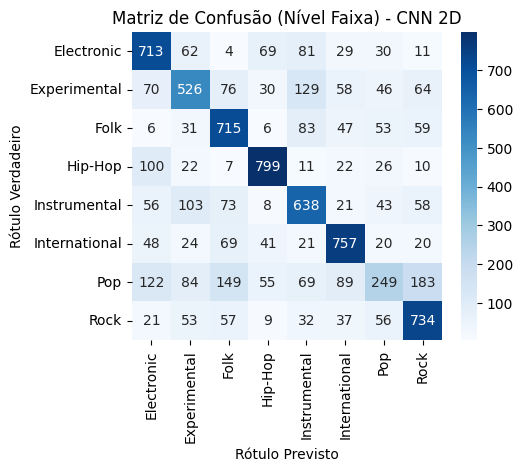

In [9]:
# Resultados da Acurácia por Faixa
mean_acc_track = np.mean(fold_scores_acc_track)
std_acc_track = np.std(fold_scores_acc_track)
print(f"\n========= Resultados Finais (Nível Faixa - Votação Majoritária) ==========")
print(f"Acurácia Média (10-Fold CV): {mean_acc_track:.4f} +/- {std_acc_track:.4f}")

# Matriz de Confusão e Relatório de Classificação Agregados (Nível Faixa)
y_true_agg = np.concatenate(all_true_track)
y_pred_agg = np.concatenate(all_preds_track)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\n--- Relatório de Classificação (Nível Faixa) ---")
print(classification_report(y_true_agg, y_pred_agg, target_names=class_names))

print("\n--- Matriz de Confusão (Nível Faixa) ---")
cm = confusion_matrix(y_true_agg, y_pred_agg)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão (Nível Faixa) - CNN 2D')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Previsto')
plt.show()